In [ ]:
!pip uninstall torch torchvision matplotlib

In [ ]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))


In [8]:
import pandas as pd

# 載入訓練資料
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

print(test_df.head())

   pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
0       0       0       0       0       0       0       0       0       0   
1       0       0       0       0       0       0       0       0       0   
2       0       0       0       0       0       0       0       0       0   
3       0       0       0       0       0       0       0       0       0   
4       0       0       0       0       0       0       0       0       0   

   pixel9  ...  pixel774  pixel775  pixel776  pixel777  pixel778  pixel779  \
0       0  ...         0         0         0         0         0         0   
1       0  ...         0         0         0         0         0         0   
2       0  ...         0         0         0         0         0         0   
3       0  ...         0         0         0         0         0         0   
4       0  ...         0         0         0         0         0         0   

   pixel780  pixel781  pixel782  pixel783  
0         0         0   

In [11]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

# 分開 features（像素）與 labels（數字類別）
X = train_df.drop('label', axis=1).values.astype(np.float32)
y = train_df['label'].values.astype(np.int64)

X_test = test_df.values.astype(np.float32)
y_test = test_df.values.astype(np.int64)

# 正規化像素值
X /= 255.0
X_test /= 255.0

# 分割 train / validation（80% / 20%）
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape 成 CNN 格式：[N, 1, 28, 28]
X_train = X_train.reshape(-1, 1, 28, 28)
X_val = X_val.reshape(-1, 1, 28, 28)
X_test = X_test.reshape(-1, 1, 28, 28)

# 轉為 TensorDataset
train_dataset = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
val_dataset = TensorDataset(torch.tensor(X_val), torch.tensor(y_val))
test_dataset = TensorDataset(torch.tensor(X_test), torch.tensor(y_test))

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [18]:
import matplotlib.pyplot as plt
import os

# 建立儲存資料夾
os.makedirs("saved_images", exist_ok=True)

# 儲存前 10 張圖片
for i in range(10):
    img = X_train[i][0]  # 取出 shape 為 [28, 28]，因為 X_train[i] 是 [1, 28, 28]
    label = y_train[i]   # 對應的標籤

    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.savefig(f"saved_images/img_{i}_label_{label}.png", bbox_inches='tight', pad_inches=0)
    plt.close()

In [12]:
print(X_val.shape)   # 應該是 (N, 1, 28, 28)
print(y_val.shape)   # 應該是 (N,)

(8400, 1, 28, 28)
(8400,)


In [5]:
for batch_x, batch_y in test_loader:
    print("batch_x.shape:", batch_x.shape)  # e.g., [64, 1, 28, 28]
    print("batch_y.shape:", batch_y.shape)  # e.g., [64]
    print("batch_y[0]:", batch_y[0])        # e.g., tensor(3)
    break


batch_x.shape: torch.Size([64, 1, 28, 28])
batch_y.shape: torch.Size([64, 784])
batch_y[0]: tensor([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  10,  17,  17,  17,
         17,  81, 180, 180,  35,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 139, 253, 253, 253,
        253, 253, 253, 253,  48,   0,   0,   0,   

In [13]:
import torch.nn as nn
import torch.nn.functional as F

class CNNTransformer(nn.Module):
    def __init__(self):
        super(CNNTransformer, self).__init__()

        # CNN 部分
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)  # → [32, 28, 28]
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)  # → [64, 28, 28]
        self.pool = nn.MaxPool2d(2, 2)  # → [64, 14, 14]

        # 將 CNN 輸出 reshape 為 Transformer 輸入：[batch, seq_len, d_model]
        self.linear_in = nn.Linear(14 * 14, 128)  # 每個 channel 當作一個 sequence item
        self.transformer_layer = nn.TransformerEncoderLayer(d_model=128, nhead=8)
        self.transformer = nn.TransformerEncoder(self.transformer_layer, num_layers=2)

        # 最後接分類器
        self.fc = nn.Linear(64 * 128, 10)  # 64 是 token 數量（channel 數），128 是每 token 的向量長度

    def forward(self, x):
        x = F.relu(self.conv1(x))     # [batch, 32, 28, 28]
        x = F.relu(self.conv2(x))     # [batch, 64, 28, 28]
        x = self.pool(x)              # [batch, 64, 14, 14]

        # 將每個 channel 當成一個 token，flatten spatial 維度
        x = x.view(x.size(0), 64, -1)           # [batch, 64, 14*14]
        x = self.linear_in(x)                   # [batch, 64, 128]
        x = x.permute(1, 0, 2)                  # → [seq_len=64, batch, d_model=128]

        x = self.transformer(x)                 # → [64, batch, 128]
        x = x.permute(1, 0, 2)                  # → [batch, 64, 128]
        x = x.reshape(x.size(0), -1)            # → [batch, 64*128]

        x = self.fc(x)                          # → [batch, 10]
        return x


In [14]:
model = CNNTransformer()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

# 訓練迴圈
for epoch in range(10):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = loss_fn(outputs, batch_y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += batch_y.size(0)
        correct += (predicted == batch_y).sum().item()

    acc = 100 * correct / total
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}, Accuracy: {acc:.2f}%")


C:\Users\admin\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1, Loss: 231.3644, Accuracy: 89.05%
Epoch 2, Loss: 43.2181, Accuracy: 97.62%
Epoch 3, Loss: 32.7116, Accuracy: 98.16%
Epoch 4, Loss: 27.9310, Accuracy: 98.35%
Epoch 5, Loss: 20.6548, Accuracy: 98.80%
Epoch 6, Loss: 21.2290, Accuracy: 98.71%
Epoch 7, Loss: 17.1926, Accuracy: 99.02%
Epoch 8, Loss: 15.5596, Accuracy: 99.06%
Epoch 9, Loss: 13.1734, Accuracy: 99.21%
Epoch 10, Loss: 14.6543, Accuracy: 99.05%


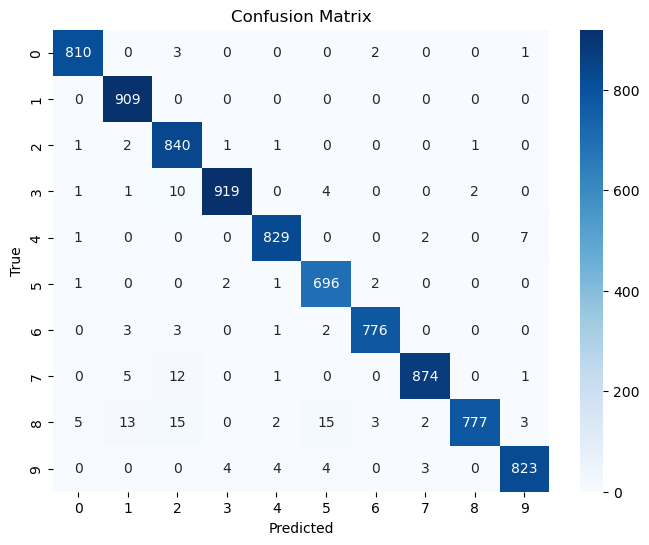

              precision    recall  f1-score   support

           0     0.9890    0.9926    0.9908       816
           1     0.9743    1.0000    0.9870       909
           2     0.9513    0.9929    0.9717       846
           3     0.9924    0.9808    0.9866       937
           4     0.9881    0.9881    0.9881       839
           5     0.9653    0.9915    0.9782       702
           6     0.9911    0.9885    0.9898       785
           7     0.9921    0.9787    0.9853       893
           8     0.9962    0.9305    0.9622       835
           9     0.9856    0.9821    0.9839       838

    accuracy                         0.9825      8400
   macro avg     0.9825    0.9826    0.9824      8400
weighted avg     0.9828    0.9825    0.9825      8400



In [15]:
import torch
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch_x, batch_y in val_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        outputs = model(batch_x)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch_y.cpu().numpy())

# 混淆矩陣
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# 精度報告
print(classification_report(all_labels, all_preds, digits=4))


In [16]:
# 保存權重
torch.save(model.state_dict(), 'model_weights.pth')

In [20]:
model = CNNTransformer()  
model.load_state_dict(torch.load('model_weights.pth'))
model.eval()

from PIL import Image
import torchvision.transforms as transforms
import torch

# 載入圖片
img = Image.open("saved_images/img_0_label_6.png").convert("L")  # 轉為灰階

# 定義轉換
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),               # → [1, 28, 28] 且自動除以 255
])

img_tensor = transform(img).unsqueeze(0)  # → [1, 1, 28, 28] 增加 batch 維度
with torch.no_grad():
    output = model(img_tensor)  # → [1, 10]
    pred = torch.argmax(output, dim=1)
    print(f"Predicted class: {pred.item()}")


Predicted class: 6
